In [18]:
from exp_loader import ExperimentLoader
from IPython.display import display
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.multicomp
from statsmodels.formula.api import ols


exp = ExperimentLoader("result")
exp.clean_saved_models(1, dry_run=False)
result = exp.results

In [19]:
def stat_test(dat: pd.DataFrame, var_name: str, print_latex: bool=False):
    m = sm.stats.anova_lm(
        ols(f"val_recall ~ C({var_name})", data=dat).fit()
    )
    if print_latex:
        print(m.to_latex())
    else:
        display(m)

    m = statsmodels.stats.multicomp.MultiComparison(
        dat['val_recall'], dat[var_name]
    ).tukeyhsd().summary()

    if print_latex:
        print(m.as_latex_tabular())
    else:
        display(m)


In [20]:
GROUPBY_KEY = ["embeddings_name", "data_name"]
METRICS_NAME = [
    "train_loss", "val_loss", "train_precision", "train_recall", 
    "train_f1", "val_precision", "val_recall", "val_f1"
]
CATEGORICAL_NAMES = ["chunk_size", "n_epoch"]
TO_REMOVE = ["n_train", "n_val", "ns_start", "ns_end", "repeat", "epoch"]
def best_model_pre_repeat(result: pd.DataFrame):
    tmp = []
    for k, df in result.groupby(["experiment_id"] + GROUPBY_KEY + ["repeat"]):
        df: pd.DataFrame
        tmp.append(
            df.sort_values(by="val_loss")[:1]
        )
    return pd.concat(tmp)


def get_metrics(result: pd.DataFrame) -> pd.DataFrame:
    df = best_model_pre_repeat(result)
    df.drop(columns=["experiment_id"])
    return df[GROUPBY_KEY + METRICS_NAME]

metrics = get_metrics(result)
print(metrics.groupby(["data_name", "embeddings_name"])[['val_loss']].count())

metrics.groupby(["data_name", "embeddings_name"]).mean()[['val_loss', 'val_recall']].sort_values(by=["val_loss", "val_recall"])

                                                  val_loss
data_name                embeddings_name                  
myexp-full               coord                          20
                         node2vec-100-100-128-1         10
                         node2vec-100-100-256-1         10
                         node2vec-100-100-32-1          24
                         node2vec-100-100-32-2          20
...                                                    ...
twor2009-full-chunk-1000 node2vec-700-1000-256-5        10
twor2009-full-chunk-200  node2vec-700-1000-256-5        10
twor2009-full-chunk-2000 node2vec-700-1000-256-5        10
twor2009-full-chunk-500  node2vec-700-1000-256-5        10
twor2009-march           node2vec-700-1000-256-5        20

[109 rows x 1 columns]


val_loss  val_recall
data_name                  embeddings_name                               
twor2009-10d-05            node2vec-700-1000-256-5   0.285647    0.948942
twor2009-10d-03            node2vec-700-1000-256-5   0.400969    0.928517
twor2009-10d-04            node2vec-700-1000-256-5   0.435051    0.904383
twor2009-10d-04-chunk-1000 node2vec-700-1000-256-5   0.448697    0.951550
myexp-half-a               node2vec-200-200-128-1    0.629676    0.902500
...                                                       ...         ...
myexp-ns-full              node2vec-100-100-32-2    17.338211    0.449062
                           node2vec-100-100-32-5    17.455997    0.399062
                           none                     17.474908    0.452500
                           node2vec-100-100-64-2    18.099400    0.300938
twor2009-full-chunk-200    node2vec-700-1000-256-5  26.672602    0.919410

[109 rows x 2 columns]

(0.85, 1.0)

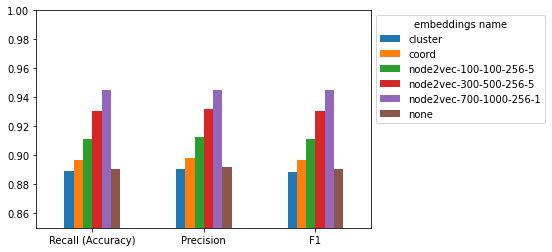

In [21]:
tmp = metrics[metrics['embeddings_name'].isin(["none", "coord", "cluster", "node2vec-700-1000-256-1", "node2vec-100-100-256-5", "node2vec-300-500-256-5"]) & (metrics['data_name'] == "twor2009-full")]

tmp.groupby(["embeddings_name"])[['val_recall', "val_precision", "val_f1"]].median()
tmp.groupby(["embeddings_name"])[['val_recall', "val_precision", "val_f1"]].median().T.plot(kind="bar")
plt.legend(bbox_to_anchor=(1, 1), title="embeddings name")
plt.gca().set_xticklabels(["Recall (Accuracy)", "Precision", "F1"], rotation=0)
plt.ylim((0.85, 1))

In [22]:
tmp = metrics.groupby(["data_name", "embeddings_name"]).median()[['val_loss', 'val_recall']].sort_values(by=["val_recall", "val_loss"], ascending=False)

In [23]:
def plot(ax: plt.Axes, dat:pd.DataFrame, key: str, sort: bool=True, sorted_by: str="val_recall", rot:int=0):
    if sort:
        order = dat.groupby(by=[key])[sorted_by].median().sort_values().index
        sns.boxplot(x=key, y='val_recall', data=dat, order=order, ax=ax)
        ax.set_xticklabels(order, rotation=rot)
    else:
        sns.boxplot(x=key, y='val_recall', data=dat, ax=ax)
    ax.set_ylabel("Accuracy")
    return ax


# complexity

32 100 100 5
2.63


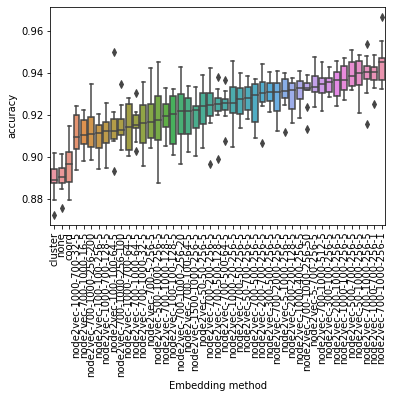

In [24]:
full_data = metrics[metrics['data_name'] == "twor2009-full"]
def image1():
    # Title: Comparison between different embedding methods
    # number of random walk, length of random walk, dimension size, window size
    order = full_data.groupby(by=['embeddings_name'])['val_recall'].median().sort_values().index
    ax = plt.axes()
    ax = sns.boxplot(
        x="embeddings_name", y="val_recall",
        data=full_data,
        order=order, 
        ax=ax
    )
    ax.set_ylabel("accuracy")
    ax.set_xlabel("Embedding method")
    ax.set_xticklabels(order, rotation=90)
    plt.show()

image1()

In [25]:
full_data.groupby(["embeddings_name"]).median()[['val_recall']].sort_values(by=["val_recall"], ascending=False)

,val_recall
embeddings_name,
node2vec-700-1000-256-1,0.945091
node2vec-1000-700-256-1,0.940485
node2vec-700-1000-256-5,0.940303
node2vec-50-1000-256-5,0.939864
node2vec-500-700-256-5,0.938409
node2vec-1000-100-256-5,0.936727
node2vec-200-1000-256-5,0.936394
node2vec-300-100-256-5,0.935758
node2vec-700-1000-512-5,0.934833


,data_name,train_loss,val_loss,train_precision,train_recall,train_f1,val_precision,val_recall,val_f1
embeddings_name,,,,,,,,,
coord,20,20,20,20,20,20,20,20,20
none,20,20,20,20,20,20,20,20,20


,df,sum_sq,mean_sq,F,PR(>F)
C(embeddings_name),1.0,0.000223,0.000223,3.081335,0.087255
Residual,38.0,0.002745,0.000072,NaN,NaN


group1,group2,meandiff,p-adj,lower,upper,reject
coord,none,-0.0047,0.0873,-0.0102,0.0007,False


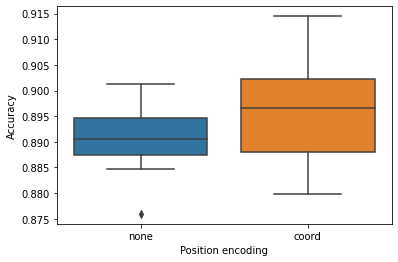

In [26]:
def plot(ax: plt.Axes, dat:pd.DataFrame, key: str, sort: bool=True, sorted_by: str="val_recall", rot:int=0):
    if sort:
        order = dat.groupby(by=[key])[sorted_by].median().sort_values().index
        sns.boxplot(x=key, y='val_recall', data=dat, order=order, ax=ax)
        ax.set_xticklabels(order, rotation=rot)
    else:
        sns.boxplot(x=key, y='val_recall', data=dat, ax=ax)
    ax.set_ylabel("Accuracy")
    return ax

naive_data = full_data[
    (full_data['embeddings_name'] == "none")
    #| (full_data['embeddings_name'] == "cluster")
    | (full_data['embeddings_name'] == "coord")
]
display(naive_data.groupby(["embeddings_name"]).count())

ax = plt.axes()
ax = plot(ax, naive_data, "embeddings_name")
ax.set_xlabel("Position encoding")

stat_test(naive_data, "embeddings_name")

In [27]:
X_g = [
    'seq_len',
    'dimension',
    'window_size',
    'walk_n',
]
def extract_nove2vec_attr():
    node2vec: pd.DataFrame = full_data[full_data['embeddings_name'].str.startswith("node2vec")]
    def split_embeddings_name():
        z = zip(node2vec['embeddings_name'].str.split("-"), node2vec['embeddings_name'])
        d = {}
        for (_, walk_n, seq_len, dimension, window_size), emb_name in z:
            d[emb_name] = dict(
                walk_n=int(walk_n),
                seq_len=int(seq_len),
                dimension=int(dimension),
                window_size=int(window_size),
            )
        return d
    node2vec = node2vec.copy()
    d = split_embeddings_name()
    for n in d:
        for x in X_g:
            node2vec.loc[node2vec['embeddings_name'] == n, x] = d[n][x]

    for x in X_g:
        node2vec[x] = node2vec[x].astype(np.int32)
    return node2vec



node2vec = extract_nove2vec_attr()

print(full_data.shape, node2vec.shape)
node2vec.groupby(by=X_g)[['val_recall']].max()

(510, 10) (450, 14)


val_recall
seq_len dimension window_size walk_n            
5       256       5           700       0.942000
20      256       5           1000      0.945788
50      256       5           50        0.938970
                              700       0.939667
100     64        5           100       0.949788
                              700       0.933515
        128       5           100       0.932485
        256       5           100       0.920273
                              300       0.942879
                              1000      0.947152
200     128       5           200       0.937697
        256       5           700       0.942030
400     256       5           1000      0.941000
500     64        5           700       0.936606
        128       5           700       0.938152
        256       5           300       0.940333
                              700       0.936970
700     32        5           1000      0.924030
        64        5           1000      0.927970
        128       5           1000      0.925394
        256       1           1000      0.948424
                  5           5         0.947394
                              50        0.938303
                              200       0.944091
                              500       0.950545
1000    16        5           700       0.922061
        32        5           700       0.935515
        64        5           700       0.930303
        128       5           700       0.932879
        256       1           700       0.966455
                  5           5         0.940061
                              50        0.948394
                              200       0.945727
                              500       0.945000
                              700       0.953455
                              1500      0.933394
                  20          700       0.942909
                  50          700       0.938970
                  100         700       0.934606
                  200         700       0.934515
        512       5           700       0.944909
2000    256       5           700       0.940879

,,val_recall
walk_n,seq_len,
700,1000,0.940303
50,1000,0.939864
500,700,0.938409
1000,100,0.936727
200,1000,0.936394
300,100,0.935758
5,700,0.933288
1000,400,0.932500
5,1000,0.931409


Text(0.5, 0, '# random walk - sequence length')

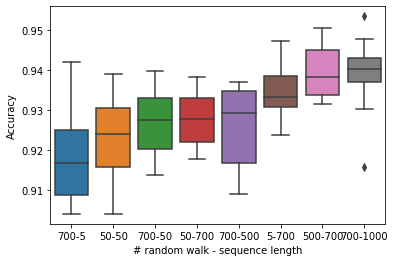

In [28]:
walk_seq = node2vec[
    (node2vec['dimension'] == 256)
    & (node2vec['window_size'] == 5)
]
display(walk_seq.groupby(by=['walk_n', 'seq_len'])[['val_recall']].median().sort_values("val_recall", ascending=False))

def _sel(walk_n, seq_len):
    return (walk_seq['seq_len'] == seq_len) & (walk_seq['walk_n'] == walk_n)

ax = plt.axes()

plot(ax,
    walk_seq[
        _sel(700, 5)
        | _sel(5, 700)
        | _sel(50, 700)
        | _sel(700, 50)
        | _sel(500, 700)
        | _sel(700, 500)
        | _sel(50, 50)
        | _sel(700, 1000)
    ], "embeddings_name", rot = 90
)
plt.gca().set_xticklabels(["700-5", "50-50", "700-50", "50-700", "700-500", "5-700", "500-700", "700-1000"], rotation=0)
plt.xlabel("# random walk - sequence length")



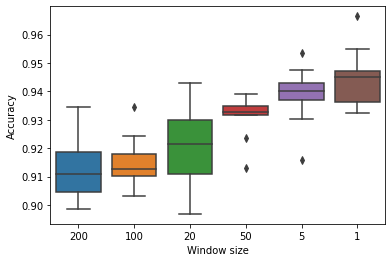

/tmp/ipykernel_748226/3734745446.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(m.to_latex())


\begin{tabular}{lrrrrr}
\toprule
{} &    df &    sum\_sq &   mean\_sq &          F &        PR(>F) \\
\midrule
C(window\_size) &   5.0 &  0.011405 &  0.002281 &  25.657312 &  6.371645e-15 \\
Residual       &  74.0 &  0.006579 &  0.000089 &        NaN &           NaN \\
\bottomrule
\end{tabular}

\begin{center}
\begin{tabular}{ccccccc}
\toprule
\textbf{group1} & \textbf{group2} & \textbf{meandiff} & \textbf{p-adj} & \textbf{lower} & \textbf{upper} & \textbf{reject}  \\
\midrule
       1        &        5        &       -0.004      &     0.7604     &    -0.0127     &     0.0047     &      False       \\
       1        &        20       &      -0.0226      &      0.0       &    -0.0333     &    -0.0119     &       True       \\
       1        &        50       &      -0.0123      &     0.0142     &     -0.023     &    -0.0017     &       True       \\
       1        &       100       &      -0.0283      &      0.0       &     -0.039     &    -0.0177     &       True       \\
       1  

In [29]:
# try window_size = 1
window_size = node2vec[(
    (node2vec["walk_n"] == 700)
    & (node2vec["seq_len"] == 1000)
    & (node2vec["dimension"] == 256)
)]
def image_window_size():
    plot(plt.axes(), window_size, "window_size", "window_size")
    plt.xlabel("Window size")
    plt.savefig("output/result_window_size.png")
    plt.show()

image_window_size()

stat_test(window_size, "window_size", print_latex=True)



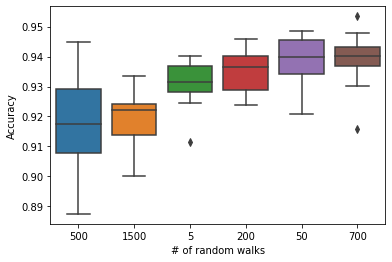

In [30]:
def image_walk_n():
    dat = node2vec[(
        #(node2vec["walk_n"] == 700)
         (node2vec["seq_len"] == 1000)
        & (node2vec["dimension"] == 256)
        & (node2vec["window_size"] == 5)
    )]
    ax = plot(plt.axes(), dat, 'walk_n', 'walk_n')
    ax.set_xlabel("# of random walks")
    plt.savefig("output/result_random_walk.png")
    plt.show()

# TO run: 500, 200, 100, 50, 10
image_walk_n()


,df,sum_sq,mean_sq,F,PR(>F)
C(dimension),1.0,0.002678,0.002678,41.705492,5.385632e-07
Residual,28.0,0.001798,0.000064,NaN,NaN


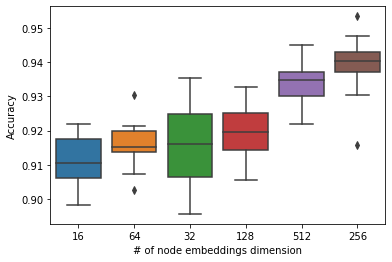

/tmp/ipykernel_748226/3734745446.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(m.to_latex())


\begin{tabular}{lrrrrr}
\toprule
{} &    df &    sum\_sq &   mean\_sq &          F &        PR(>F) \\
\midrule
C(dimension) &   5.0 &  0.008996 &  0.001799 &  23.991583 &  1.650976e-13 \\
Residual     &  64.0 &  0.004799 &  0.000075 &        NaN &           NaN \\
\bottomrule
\end{tabular}

\begin{center}
\begin{tabular}{ccccccc}
\toprule
\textbf{group1} & \textbf{group2} & \textbf{meandiff} & \textbf{p-adj} & \textbf{lower} & \textbf{upper} & \textbf{reject}  \\
\midrule
       16       &        32       &       0.0056      &     0.7034     &    -0.0058     &     0.017      &      False       \\
       16       &        64       &       0.005       &     0.7841     &    -0.0063     &     0.0164     &      False       \\
       16       &       128       &       0.0089      &     0.2138     &    -0.0025     &     0.0202     &      False       \\
       16       &       256       &       0.0289      &      0.0       &     0.0191     &     0.0388     &       True       \\
       16      

In [31]:

dim_size_dat = node2vec[(
    (node2vec["walk_n"] == 700)
    & (node2vec["seq_len"] == 1000)
    & (node2vec["window_size"] == 5)
)]


m = sm.stats.anova_lm(
    ols("val_recall ~ C(dimension)", data=dim_size_dat[
        (dim_size_dat['dimension'] == 256)
        | (dim_size_dat['dimension'] == 128)
    ]).fit()
)
display(m)

def image_dim_size():
    ax = plot(plt.axes(), dim_size_dat, 'dimension', 'dimension')
    ax.set_xlabel("# of node embeddings dimension")
    plt.savefig("output/result_dimension.png")
    plt.show()

image_dim_size()
stat_test(dim_size_dat, 'dimension', print_latex=True)

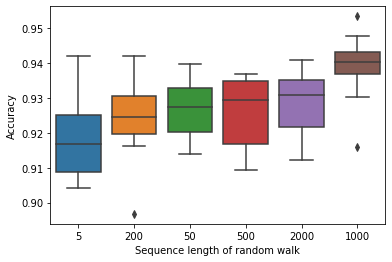

In [32]:
def image_seq_len():
    dat = node2vec[(
        (node2vec["walk_n"] == 700)
        #& (node2vec["seq_len"] == 1000)
        & (node2vec["dimension"] == 256)
        & (node2vec["window_size"] == 5)
    )]
    ax = plot(plt.axes(), dat, 'seq_len', 'seq_len')
    ax.set_xlabel("Sequence length of random walk")
    plt.show()

image_seq_len()


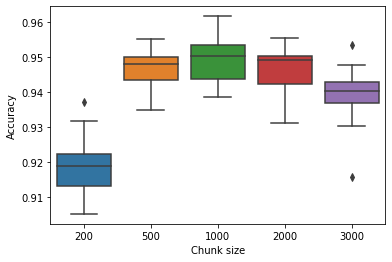

In [35]:
def get_chunk_data():
    chunk_data = metrics[metrics['data_name'].str.startswith("twor2009-full-chunk")].copy()
    d = {}
    for n in chunk_data['data_name'].unique():
        d[n] = int(n.split("-")[3])

    for k, v in d.items():
        chunk_data.loc[chunk_data['data_name'] == k, "chunk_size"] = v

    o = full_data[full_data['embeddings_name'] == "node2vec-700-1000-256-5"].copy()
    o['chunk_size'] = 3000
    df = pd.concat(
        (chunk_data, o)
    )
    df.reindex()
    df['chunk_size'] = df['chunk_size'].astype('int64')
    return df

    
chunk_data = get_chunk_data()


def image_chunk_size():
    dat = chunk_data
    ax = plt.axes()
    ax = plot(ax, dat, 'chunk_size', sorted_by='chunk_size')
    ax.set_xlabel("Chunk size")
    plt.savefig("output/result_chunk_size.png")
    plt.show()

image_chunk_size()




In [36]:
chunk_data = chunk_data[chunk_data['chunk_size'] != 200]

m = sm.stats.anova_lm(
    ols("val_recall ~ C(chunk_size)", data=chunk_data).fit()
)
print(m.to_latex())

m = statsmodels.stats.multicomp.MultiComparison(
    chunk_data['val_recall'], chunk_data['chunk_size']
).tukeyhsd().summary()

print(m.as_latex_tabular())




\begin{tabular}{lrrrrr}
\toprule
{} &    df &    sum\_sq &   mean\_sq &         F &    PR(>F) \\
\midrule
C(chunk\_size) &   3.0 &  0.000785 &  0.000262 &  5.021348 &  0.004287 \\
Residual      &  46.0 &  0.002398 &  0.000052 &       NaN &       NaN \\
\bottomrule
\end{tabular}

\begin{center}
\begin{tabular}{ccccccc}
\toprule
\textbf{group1} & \textbf{group2} & \textbf{meandiff} & \textbf{p-adj} & \textbf{lower} & \textbf{upper} & \textbf{reject}  \\
\midrule
      500       &       1000      &       0.0027      &     0.8439     &     -0.006     &     0.0113     &      False       \\
      500       &       2000      &      -0.0001      &      1.0       &    -0.0087     &     0.0085     &      False       \\
      500       &       3000      &       -0.007      &     0.0741     &    -0.0144     &     0.0005     &      False       \\
      1000      &       2000      &      -0.0027      &     0.8334     &    -0.0113     &     0.0059     &      False       \\
      1000      &       300

/tmp/ipykernel_748226/3429432752.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(m.to_latex())


,embeddings_name,data_name,train_loss,val_loss,train_precision,train_recall,train_f1,val_precision,val_recall,val_f1
27,node2vec-700-1000-256-5,twor2009-full-chunk-1000,10.434517,4.202146,0.955011,0.954885,0.954875,0.950814,0.950394,0.950374
35,node2vec-700-1000-256-5,twor2009-full-chunk-1000,9.862248,3.995424,0.952427,0.952333,0.952324,0.956745,0.955515,0.955472
36,node2vec-700-1000-256-5,twor2009-full-chunk-1000,11.509734,4.695178,0.950963,0.950823,0.950810,0.944969,0.943667,0.943608
35,node2vec-700-1000-256-5,twor2009-full-chunk-1000,11.059530,4.855601,0.951016,0.950990,0.950985,0.938744,0.938636,0.938627
36,node2vec-700-1000-256-5,twor2009-full-chunk-1000,9.616945,4.107596,0.959814,0.959760,0.959755,0.955553,0.953939,0.953883
...,...,...,...,...,...,...,...,...,...,...
38,node2vec-700-500-256-5,twor2009-full,4.377753,2.017014,0.940536,0.940344,0.940324,0.916443,0.914606,0.914565
38,node2vec-700-500-256-5,twor2009-full,3.447953,2.045809,0.954351,0.954323,0.954318,0.923258,0.923242,0.923245
30,node2vec-700-500-256-5,twor2009-full,4.816217,1.946058,0.936555,0.936323,0.936299,0.936170,0.934333,0.934224
29,node2vec-700-500-256-5,twor2009-full,4.889893,2.020588,0.933926,0.933656,0.933629,0.929873,0.925303,0.925030


,embeddings_name,train_loss,val_loss,train_precision,train_recall,train_f1,val_precision,val_recall,val_f1
data_name,,,,,,,,,
myexp-full,164,164,164,164,164,164,164,164,164
myexp-half-a,160,160,160,160,160,160,160,160,160
myexp-half-b,160,160,160,160,160,160,160,160,160
myexp-ns-full,60,60,60,60,60,60,60,60,60
myexp-ns-half-a,60,60,60,60,60,60,60,60,60
myexp-ns-half-b,60,60,60,60,60,60,60,60,60
twor2009-10d-01,20,20,20,20,20,20,20,20,20
twor2009-10d-01-chunk-1000,10,10,10,10,10,10,10,10,10
twor2009-10d-02,20,20,20,20,20,20,20,20,20


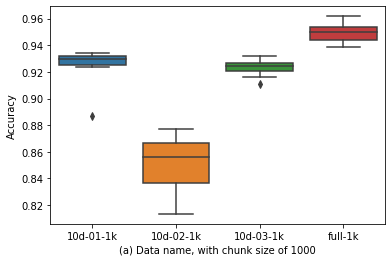

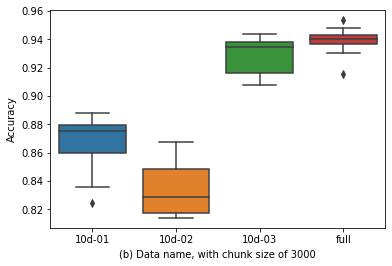

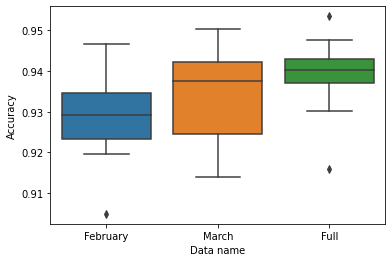

/tmp/ipykernel_748226/3734745446.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(m.to_latex())
/tmp/ipykernel_748226/3734745446.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(m.to_latex())


\begin{tabular}{lrrrrr}
\toprule
{} &    df &    sum\_sq &   mean\_sq &         F &    PR(>F) \\
\midrule
C(data\_name) &   2.0 &  0.001129 &  0.000565 &  6.238725 &  0.003547 \\
Residual     &  57.0 &  0.005160 &  0.000091 &       NaN &       NaN \\
\bottomrule
\end{tabular}

\begin{center}
\begin{tabular}{ccccccc}
\toprule
\textbf{group1} & \textbf{group2} & \textbf{meandiff} & \textbf{p-adj} & \textbf{lower} & \textbf{upper} & \textbf{reject}  \\
\midrule
  twor2009-feb  &  twor2009-full  &       0.0106      &     0.0023     &     0.0034     &     0.0179     &       True       \\
  twor2009-feb  &  twor2009-march &       0.0051      &      0.21      &    -0.0021     &     0.0124     &      False       \\
 twor2009-full  &  twor2009-march &      -0.0055      &     0.1719     &    -0.0127     &     0.0018     &      False       \\
\bottomrule
\end{tabular}
%\caption{Multiple Comparison of Means - Tukey HSD, FWER=0.05}
\end{center}
\begin{tabular}{lrrrrr}
\toprule
{} &    df &    sum\_

,val_recall
data_name,
twor2009-10d-01-chunk-1000,0.929333
twor2009-10d-02-chunk-1000,0.855900
twor2009-10d-03-chunk-1000,0.924100
twor2009-full-chunk-1000,0.950273


,val_recall
data_name,
twor2009-10d-01,0.875083
twor2009-10d-02,0.828750
twor2009-10d-03,0.934583
twor2009-full,0.940303


,val_recall
data_name,
twor2009-feb,0.929067
twor2009-full,0.940303
twor2009-march,0.937472


In [38]:
other_data = metrics[metrics['data_name'] != "twor2009-full"]
display(other_data.groupby(['data_name']).count())

baseline_dat = metrics[(metrics['data_name'] == 'twor2009-full') & (metrics['embeddings_name'] == 'node2vec-700-1000-256-5')]
baseline_chunk_1000_dat = metrics[(metrics['data_name'] == 'twor2009-full-chunk-1000') & (metrics['embeddings_name'] == 'node2vec-700-1000-256-5')]

monthly_dat = other_data[
    (other_data['data_name'] == 'twor2009-march')
    | (other_data['data_name'] == 'twor2009-feb')
]
monthly_dat = pd.concat((monthly_dat, baseline_dat))

data_10d = pd.concat((other_data[
     (other_data['data_name'] == "twor2009-10d-01")
    | (other_data['data_name'] == "twor2009-10d-02")
    | (other_data['data_name'] == "twor2009-10d-03")
], baseline_dat))
data_10d_chunk_1000 = pd.concat((other_data[
     (other_data['data_name'] == "twor2009-10d-01-chunk-1000")
    | (other_data['data_name'] == "twor2009-10d-02-chunk-1000")
    | (other_data['data_name'] == "twor2009-10d-03-chunk-1000")
], baseline_chunk_1000_dat))

ax = plt.axes()
ax = plot(ax, data_10d_chunk_1000, 'data_name', sort=False, rot=90)
ax.set_xticklabels(["10d-01-1k", "10d-02-1k", "10d-03-1k", "full-1k"])
ax.set_xlabel("(a) Data name, with chunk size of 1000")
plt.show()

data_smaller_chunk3000 = pd.concat((data_10d, monthly_dat))

ax = plt.axes()
ax = plot(ax, data_10d, 'data_name', sort=False, rot=90)
ax.set_xticklabels(["10d-01", "10d-02", "10d-03", "full"])
ax.set_xlabel("(b) Data name, with chunk size of 3000")
plt.show()

ax = plt.axes()
ax = plot(ax, monthly_dat, 'data_name', sort=False, rot=90)
ax.set_xticklabels(["February", "March", "Full"])
ax.set_xlabel("Data name")
plt.show()

stat_test(monthly_dat, "data_name", print_latex=True)
stat_test(data_10d_chunk_1000, "data_name", print_latex=True)


display(data_10d_chunk_1000.groupby(['data_name'])[['val_recall']].median())
display(data_10d.groupby(['data_name'])[['val_recall']].median())
display(monthly_dat.groupby(['data_name'])[['val_recall']].median())

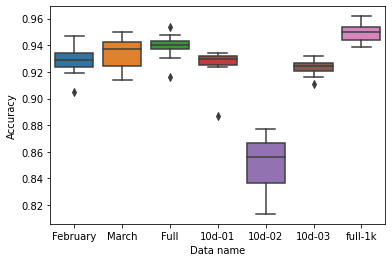

In [39]:

ax = plt.axes()
ax = plot(ax,
    pd.concat((monthly_dat, data_10d_chunk_1000)), 'data_name', sort=False)
ax.set_xticklabels(["February", "March", "Full", "10d-01", "10d-02", "10d-03", "full-1k"])
ax.set_xlabel("Data name")
plt.show()

[Text(0, 0, 'TWOR full-1k: 128k'),
 Text(0, 1, 'TWOR full: 128k'),
 Text(0, 2, 'TWOR March: 69k'),
 Text(0, 3, 'TWOR 10d-01: 23k'),
 Text(0, 4, 'TWOR Feb: 59k'),
 Text(0, 5, 'TWOR 10d-03: 20k'),
 Text(0, 6, 'Myexp half-b: 1k'),
 Text(0, 7, 'TWOR 10d-02: 17k'),
 Text(0, 8, 'Myexp full: 2k'),
 Text(0, 9, 'Myexp half-a: 1k')]

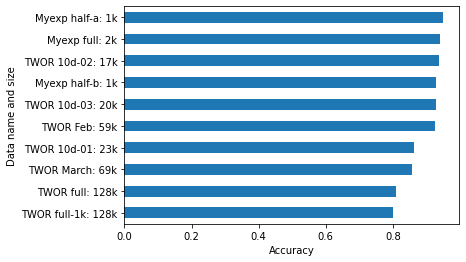

In [67]:

tmp = metrics[
    (
        (metrics['data_name'].str.startswith("myexp") 
        & ~metrics['data_name'].str.startswith("myexp-ns"))

    )
    #& (metrics['val_recall'] >= 0.7)
]

tmp = pd.concat(
    (tmp, monthly_dat, data_10d_chunk_1000)
)



tmp = tmp.groupby(["data_name"])["val_recall"].median().sort_values()

d = {
"twor2009-march": 69000,
"twor2009-feb": 59659,
"twor2009-10d-01-chunk-1000": 23227,
"twor2009-10d-02-chunk-1000": 17626,
"twor2009-10d-03-chunk-1000": 20228,
"twor2009-10d-04-chunk-1000": 15159,
"twor2009-10d-05-chunk-1000": 18520,
"twor2009-full-chunk-1000": 128660,
"twor2009-full": 128660,
"myexp-full": 1900,
"myexp-half-a": 950,
"myexp-half-b": 950,
}

tmp.plot.barh()
plt.ylabel("Data name and size")
plt.xlabel("Accuracy")
plt.gca().set_yticklabels([
    "TWOR full-1k: 128k",
    "TWOR full: 128k",
    "TWOR March: 69k",
    "TWOR 10d-01: 23k",
    "TWOR Feb: 59k",
    "TWOR 10d-03: 20k",
    "Myexp half-b: 1k",
    "TWOR 10d-02: 17k",
    "Myexp full: 2k",
    "Myexp half-a: 1k"])


